In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os
from collections import defaultdict
from copy import deepcopy

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def alter_pathway(input_filename, output_filename, alterations):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(input_filename)
    model = document.getModel()

    for i in range(model.getNumParameters()):
        param = model.getParameter(i)
        if param.getId() == alterations:
            previous_value = param.getValue()
            param.setValue(previous_value * 100)
            modified_sbml = libsbml.writeSBML(document, output_filename)
            return 

In [4]:
def generate_test_set(filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    for i in range(model.getNumParameters()):
        base_dir = 'altered_pathways2'
        alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
        file_dir = os.path.join(alteration_dir, 'reaction_' + str(i) + '100x.xml')
        os.makedirs(alteration_dir, exist_ok=True)
        
        param = model.getParameter(i)

        alter_pathway(filename, file_dir, param.getId())

In [5]:
generate_test_set('BIOMD0000000028.xml')

In [6]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) >= 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [7]:
convert_sbml_to_network('BIOMD0000000028.xml')

number reactions 17
number species 16


In [8]:
for i in range(len(description['reactions'])):
    desc = deepcopy(description)
    desc['altered'] = desc['reactions'][i][0]
    base_dir = 'altered_pathways2'
    alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
    description_path = os.path.join(alteration_dir, 'description')
    description_file = open(description_path, 'wb')
    pickle.dump(desc, description_file)
    description_file.close()
    

In [9]:
desc_path = 'altered_pathways2/reaction_21/description'
desc_file = open(desc_path, 'rb')
temp = pickle.load(desc_file)
desc_file.close()
temp

{'species': ['M',
  'MpY',
  'MpT',
  'Mpp',
  'MEK',
  'MKP3',
  'MpY_MEK',
  'MpT_MEK',
  'M_MEK_Y',
  'M_MEK_T',
  'Mpp_MKP3',
  'MpY_MKP3',
  'MpT_MKP3_Y',
  'MpT_MKP3_T',
  'M_MKP3_T',
  'M_MKP3_Y'],
 'reactions': [['reaction_0000001', 0, 1],
  ['reaction_0000001revert', 0, 1],
  ['reaction_0000002', 0, 1],
  ['reaction_0000003', 0, 1],
  ['reaction_0000003revert', 0, 1],
  ['reaction_0000004', 0, 1],
  ['reaction_0000005', 0, 1],
  ['reaction_0000005revert', 0, 1],
  ['reaction_0000006', 0, 1],
  ['reaction_0000007', 0, 1],
  ['reaction_0000007revert', 0, 1],
  ['reaction_0000008', 0, 1],
  ['reaction_0000009', 0, 1],
  ['reaction_0000009revert', 0, 1],
  ['reaction_0000010', 0, 1],
  ['reaction_0000011', 0, 1],
  ['reaction_0000011revert', 0, 1],
  ['reaction_0000012', 0, 1],
  ['reaction_0000013', 0, 1],
  ['reaction_0000013revert', 0, 1],
  ['reaction_0000014', 0, 1],
  ['reaction_0000015', 0, 1],
  ['reaction_0000015revert', 0, 1],
  ['reaction_0000017', 0, 1],
  ['reaction_0

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000028.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 7782.0
Converged at time 1503.0
Specie:  M expected result:  decreased  normal final:  125.87674522253224  altered final:  51.64677157763936
confidence interval:  [0.3525969898997335, 0.36272351367801786]
deltas coming from simulation:  [-74.22997364489288, 0]
Specie:  MpY expected result:  increased  normal final:  235.19383611381477  altered final:  479.8115022574329
confidence interval:  [0.9628984540296801, 0.9681458760607381]
deltas coming from simulation:  [244.61766614361812, 0]
Specie:  MpT expected result:  decreased  normal final:  71.66042904680344  altered final:  13.796611866681403
confidence interval:  [0.3541457038512844, 0.3621407903164705]
deltas coming from simulation:  [-57.86381718012204, 0]
Specie:  Mpp expected result:  decreased  normal final:  105.49306832686293  altered final:  12.23706156730017
confidence interval:  [0.3637028099277968, 0.3802273968248373]
deltas coming from simulation:  [-93.25600675956275, 0]
Specie:  MEK expected result:  

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.6597222222222222


In [4]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 1278,
 'uncertain_species': 22,
 'correct_species': 899,
 'true_positives': 444,
 'false_positives': 198,
 'false_negatives': 181,
 'true_negatives': 455}

In [4]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  432  correct:  285  uncertain:  5  true pos:  122  true neg:  163  false_pos:  94 false neg:  53


In [6]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [7]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [4]:
scores

[0.6875,
 0.625,
 0.875,
 0.875,
 0.375,
 0.75,
 0.5625,
 0.75,
 0.5625,
 0.5625,
 0.625,
 0.875,
 0.8125,
 0.5,
 0.6875,
 0.5625,
 0.75,
 0.875,
 0.75,
 0.5,
 0.5,
 0.6875,
 0.75,
 0.5625,
 0.75,
 0.875,
 0.5]

In [6]:
description

{'species': ['M',
  'MpY',
  'MpT',
  'Mpp',
  'MEK',
  'MKP3',
  'MpY_MEK',
  'MpT_MEK',
  'M_MEK_Y',
  'M_MEK_T',
  'Mpp_MKP3',
  'MpY_MKP3',
  'MpT_MKP3_Y',
  'MpT_MKP3_T',
  'M_MKP3_T',
  'M_MKP3_Y'],
 'reactions': [['reaction_0000001', 0, 1],
  ['reaction_0000001revert', 0, 1],
  ['reaction_0000002', 0, 1],
  ['reaction_0000003', 0, 1],
  ['reaction_0000003revert', 0, 1],
  ['reaction_0000004', 0, 1],
  ['reaction_0000005', 0, 1],
  ['reaction_0000005revert', 0, 1],
  ['reaction_0000006', 0, 1],
  ['reaction_0000007', 0, 1],
  ['reaction_0000007revert', 0, 1],
  ['reaction_0000008', 0, 1],
  ['reaction_0000009', 0, 1],
  ['reaction_0000009revert', 0, 1],
  ['reaction_0000010', 0, 1],
  ['reaction_0000011', 0, 1],
  ['reaction_0000011revert', 0, 1],
  ['reaction_0000012', 0, 1],
  ['reaction_0000013', 0, 1],
  ['reaction_0000013revert', 0, 1],
  ['reaction_0000014', 0, 1],
  ['reaction_0000015', 0, 1],
  ['reaction_0000015revert', 0, 1],
  ['reaction_0000017', 0, 1],
  ['reaction_0

In [7]:
description['altered'] = 'reaction_0000002'
description

{'species': ['M',
  'MpY',
  'MpT',
  'Mpp',
  'MEK',
  'MKP3',
  'MpY_MEK',
  'MpT_MEK',
  'M_MEK_Y',
  'M_MEK_T',
  'Mpp_MKP3',
  'MpY_MKP3',
  'MpT_MKP3_Y',
  'MpT_MKP3_T',
  'M_MKP3_T',
  'M_MKP3_Y'],
 'reactions': [['reaction_0000001', 0, 1],
  ['reaction_0000001revert', 0, 1],
  ['reaction_0000002', 0, 1],
  ['reaction_0000003', 0, 1],
  ['reaction_0000003revert', 0, 1],
  ['reaction_0000004', 0, 1],
  ['reaction_0000005', 0, 1],
  ['reaction_0000005revert', 0, 1],
  ['reaction_0000006', 0, 1],
  ['reaction_0000007', 0, 1],
  ['reaction_0000007revert', 0, 1],
  ['reaction_0000008', 0, 1],
  ['reaction_0000009', 0, 1],
  ['reaction_0000009revert', 0, 1],
  ['reaction_0000010', 0, 1],
  ['reaction_0000011', 0, 1],
  ['reaction_0000011revert', 0, 1],
  ['reaction_0000012', 0, 1],
  ['reaction_0000013', 0, 1],
  ['reaction_0000013revert', 0, 1],
  ['reaction_0000014', 0, 1],
  ['reaction_0000015', 0, 1],
  ['reaction_0000015revert', 0, 1],
  ['reaction_0000017', 0, 1],
  ['reaction_0

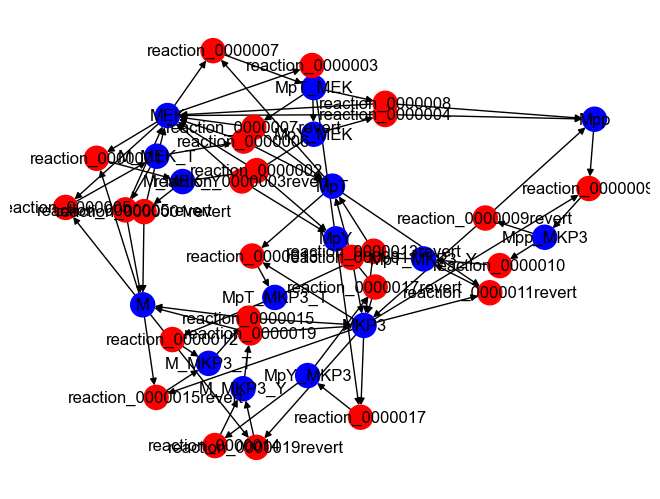

In [8]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [8]:
description_path = 'description_reaction_0000002_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

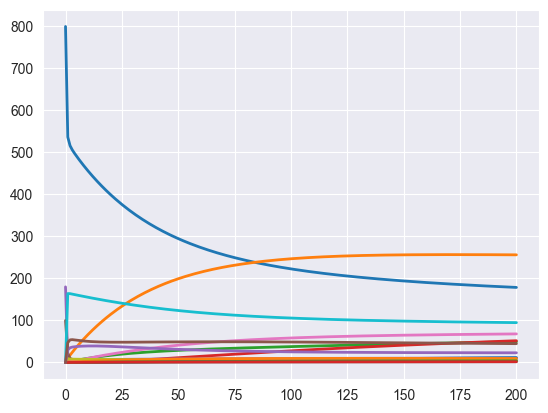

       time,     [M],   [MpY],   [MpT],      [Mpp],   [MEK],  [MKP3], [MpY_MEK], [MpT_MEK], [M_MEK_Y], [M_MEK_T],  [Mpp_MKP3], [MpY_MKP3], [MpT_MKP3_Y], [MpT_MKP3_T], [M_MKP3_T], [M_MKP3_Y]
 [[       0,     800,       0,       0,          0,     180,     100,         0,         0,         0,         0,           0,          0,            0,            0,          0,          0],
  [ 1.00503, 536.695, 10.0596, 1.01054, 0.00263771, 6.20236, 21.5655,  0.618835, 0.0100317,   9.09842,    164.07, 0.000750805,    1.15142,     0.121985,     0.102709,    29.7626,     47.295],
  [ 2.01005, 516.258, 17.5228, 2.15796,  0.0167918, 6.36519, 9.59002,   1.66903, 0.0309829,   8.07239,   163.862,   0.0033825,    1.20691,     0.176233,     0.130171,     35.052,    53.8413],
  [ 3.01508,  506.03, 24.4774, 3.30893,  0.0466468, 6.44251, 7.42069,    2.7971, 0.0559847,   7.88353,   162.821,  0.00831548,     1.1871,      0.20847,     0.147222,    36.6602,     54.368],
  [  4.0201, 497.826, 31.1104, 4.39951,  0

In [9]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000028.xml')

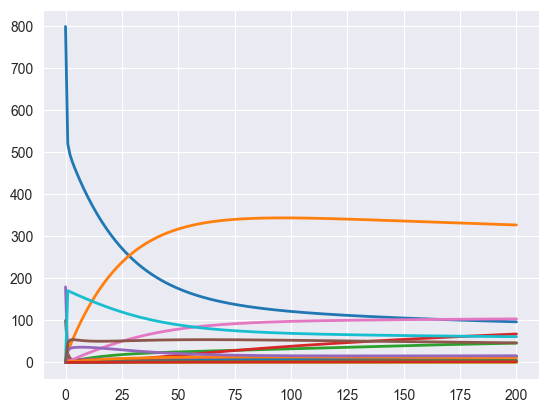

       time,     [M],   [MpY],   [MpT],      [Mpp],   [MEK],  [MKP3], [MpY_MEK], [MpT_MEK], [M_MEK_Y], [M_MEK_T], [Mpp_MKP3], [MpY_MKP3], [MpT_MKP3_Y], [MpT_MKP3_T], [M_MKP3_T], [M_MKP3_Y]
 [[       0,     800,       0,       0,          0,     180,     100,         0,         0,         0,         0,          0,          0,            0,            0,          0,          0],
  [ 1.00503, 520.573, 25.8266, 1.07221, 0.00883672, 6.53339, 20.9472,    2.3533, 0.0112158,  0.156034,   170.946, 0.00338062,    3.96848,     0.126314,     0.106227,    28.5017,    46.3467],
  [ 2.01005, 494.388, 39.7051, 2.25535,  0.0367135, 6.77641, 9.60888,   4.44753, 0.0345356,  0.153699,   168.588, 0.00870709,    3.10499,     0.183438,      0.13542,    33.5193,    53.4392],
  [ 3.01508, 477.855, 52.9476,  3.4285,  0.0883325, 6.90504,  7.4145,   6.76351, 0.0622222,  0.151379,   166.118,  0.0171319,    2.71603,     0.217578,     0.153308,    35.0535,     54.428],
  [  4.0201,   463.7, 65.4344, 4.53477,   0.162

In [10]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000028_reaction2_100x.xml')

In [11]:
species = description['species']
species

['M',
 'MpY',
 'MpT',
 'Mpp',
 'MEK',
 'MKP3',
 'MpY_MEK',
 'MpT_MEK',
 'M_MEK_Y',
 'M_MEK_T',
 'Mpp_MKP3',
 'MpY_MKP3',
 'MpT_MKP3_Y',
 'MpT_MKP3_T',
 'M_MKP3_T',
 'M_MKP3_Y']

In [12]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [13]:
final_normal

[200.         178.68776193 256.29535491  49.42885212  51.74932237
  10.69704016   5.46425117  68.01891589   1.81987267   4.59607183
  94.86809945  11.61737009   9.5299374    3.76190193   1.7987274
  23.01702607  44.81078594]

In [14]:
temp = final_concentrations_normal[1]
temp

[800.   0.   0.   0. 180. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]

In [15]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

M
final normal:  178.68776192609457 final altered:  96.77587350467226 delta:  -81.9118884214223 relative delta  -0.45840793761411114 initial concentration:  800.0 delta1 0.10238986052677788 delta2 0.45840793761411114
MpY
final normal:  256.29535491240006 final altered:  327.3591477023484 delta:  71.06379278994837 relative delta  0.27727304232352346 initial concentration:  0.0 delta1 0 delta2 0.27727304232352346
MpT
final normal:  49.42885212346414 final altered:  46.11008403497632 delta:  -3.318768088487822 relative delta  -0.0671423257047959 initial concentration:  0.0 delta1 0 delta2 0.06714232570479595
Mpp
final normal:  51.749322365950356 final altered:  67.83559533245051 delta:  16.086272966500154 relative delta  0.3108499248114693 initial concentration:  0.0 delta1 0 delta2 0.31084992481146934
MEK
final normal:  10.697040158375804 final altered:  12.773312514956483 delta:  2.076272356580679 relative delta  0.19409783695679161 initial concentration:  180.0 delta1 0.011534846425448

In [16]:
expected_results

{'M': 'decreased',
 'MpY': 'increased',
 'MpT': 'unchanged',
 'Mpp': 'increased',
 'MEK': 'increased',
 'MKP3': 'unchanged',
 'MpY_MEK': 'increased',
 'MpT_MEK': 'increased',
 'M_MEK_Y': 'decreased',
 'M_MEK_T': 'decreased',
 'Mpp_MKP3': 'increased',
 'MpY_MKP3': 'increased',
 'MpT_MKP3_Y': 'unchanged',
 'MpT_MKP3_T': 'unchanged',
 'M_MKP3_T': 'decreased',
 'M_MKP3_Y': 'unchanged'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

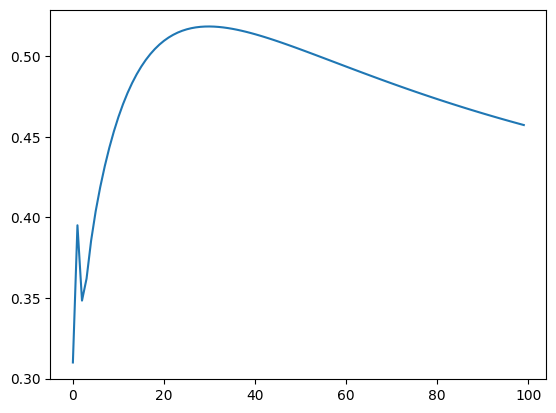

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [17]:
res = complete_tests.complete_tests2(
            'BIOMD0000000028.xml',
            'BIOMD0000000028_reaction2_100x.xml',
            'description_reaction_0000002_altered',
            []
        )

In [18]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  M expected result:  decreased
confidence interval:  [0.32322082857691, 0.3254673429648965]
Specie:  MpY expected result:  increased
confidence interval:  [0.6265217708499653, 0.6309925228384137]
Specie:  MpT expected result:  increased
confidence interval:  [0.4769573107345439, 0.48033886668375264]
Specie:  Mpp expected result:  increased
confidence interval:  [0.7526376775524989, 0.7580826021180284]
Specie:  MEK expected result:  increased
confidence interval:  [0.6400634661985158, 0.6413118684972929]
Specie:  MKP3 expected result:  decreased
confidence interval:  [0.45455035033503727, 0.4576920094026797]
Specie:  MpY_MEK expected result:  increased
confidence interval:  [0.5629972008513933, 0.5643211331678741]
Specie:  MpT_MEK expected result:  increased
confidence interval:  [0.5284781392996527, 0.5293081299846987]
Specie:  M_MEK_Y expected result:  decreased
confidence interval:  [0.3941164461528786, 0.3959149616980702]
Specie:  M_MEK_T expected result:  decreased
confiden

In [19]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  16 correct experiments:  15 ratio:  0.9375


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

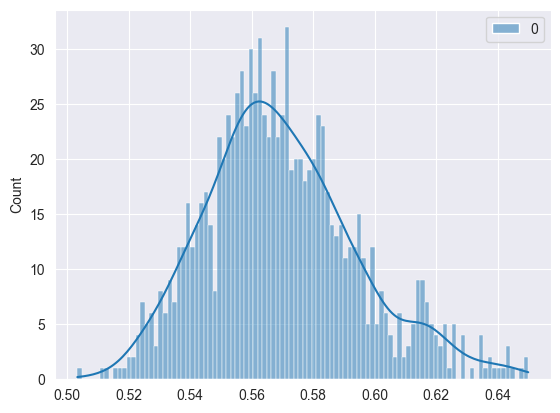

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)